# Ray et al 2013 Evaluation
**Authorship:**
Adam Klie, *08/31/2022*
***
**Description:**
Notebook to evaluate trained models on the Ray et al (2013) dataset. Evaulating across all k-mers is a very, very slow process. Please check out the accompanying `ray13_evaluation_{setA|ST|MT|Kipoi}.py` scripts, along with the SLURM `ray13_evaluation.sh` script for how to run this on a compute cluster over multiple days.
***

In [96]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# General imports
import os
import glob
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning
from tqdm.auto import tqdm

In [105]:
# EUGENe imports and settings
import eugene as eu
from eugene import models
from eugene.models import zoo
from eugene import train
from eugene import evaluate
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/ray13"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/ray13"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/ray13"

# EUGENe packages
import seqdata as sd

# ray13 helpers
sys.path.append("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/scripts/ray13")
from ray13_helpers import rnacomplete_metrics, rnacomplete_metrics_sdata_table

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Eugene version: {eu.__version__}")
#print(f"SeqData version: {sd.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pytorch_lightning.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Eugene version: 0.0.8
PyTorch version: 2.0.0
PyTorch Lightning version: 2.0.0


In [113]:
# Load the test data
sdata_test = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setB_ST.zarr"))
keys = pd.Index(sdata_test.data_vars.keys())
target_mask = keys.str.contains("RNCMPT")
target_cols = keys[target_mask]

# Load in the Set B presence/absence predictions
b_presence_absence = np.load(os.path.join(settings.dataset_dir, "setB_binary.npy"))
setB_observed = sdata_test[target_cols]

# Also need the multi-task columns (single task we could train on all the columns)
sdata_training = sd.open_zarr(os.path.join(eu.settings.dataset_dir, "norm_setA_sub_MT.zarr"))
keys_MT = pd.Index(sdata_training.data_vars.keys())
target_mask_MT = keys_MT.str.contains("RNCMPT")
target_cols_MT = keys_MT[target_mask_MT]
del sdata_training

In [114]:
target_cols_MT

Index(['RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004',
       'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00010',
       'RNCMPT00011', 'RNCMPT00012',
       ...
       'RNCMPT00280', 'RNCMPT00281', 'RNCMPT00282', 'RNCMPT00283',
       'RNCMPT00284', 'RNCMPT00285', 'RNCMPT00287', 'RNCMPT00288',
       'RNCMPT00289', 'RNCMPT00291'],
      dtype='object', length=233)

# Number of kmers to use 

In [9]:
number_kmers = 10

# Load in the test `SeqData`

In [10]:
# Load the test data
sdata_test = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setB_ST.zarr"))
keys = pd.Index(sdata_test.data_vars.keys())
target_mask = keys.str.contains("RNCMPT")
target_cols = keys[target_mask]
sdata_test

<xarray.Dataset>
Dimensions:      (_sequence: 121031, _ohe: 4, length: 41)
Dimensions without coordinates: _sequence, _ohe, length
Data variables: (12/248)
    Probe_ID     (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    Probe_Set    (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNA_Seq      (_sequence) object dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00001  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00002  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00003  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ...           ...
    RNCMPT00285  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00287  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00288  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00289  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    RNCMPT00291  (_sequence) float64 dask.array<chunksize=(30258,), meta=np.ndarray>
    ohe_seq      (_sequence, _ohe, length) float16 dask.array<chunksize=(30258, 1, 11), meta=np.ndarray>

In [11]:
# Load in the Set B presence/absence predictions
b_presence_absence = np.load(os.path.join(settings.dataset_dir, "setB_binary.npy"))
setB_observed = sdata_test[target_cols]

# Get test set evaluations for each model

## SetA k-mer scores 

In [59]:
# Load in the Set A presence/absence predictions
a_presence_absence = np.load(os.path.join(settings.dataset_dir, "setA_binary_ST.npy"))
setA_observed = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setA_ST.zarr"))[target_cols]

In [68]:
if number_kmers is not None:
    random_kmers = np.random.choice(np.arange(a_presence_absence.shape[0]), size=number_kmers)
    a_presence_absence = a_presence_absence[random_kmers, :]
    b_presence_absence = b_presence_absence[random_kmers, :]
valid_kmers = np.where((np.sum(a_presence_absence, axis=1) > 0) & (np.sum(b_presence_absence, axis=1) > 0))[0]
a_presence_absence = a_presence_absence[valid_kmers, :]
b_presence_absence = b_presence_absence[valid_kmers, :]

In [69]:
# An example calculation of z-scores, aucs and e-scores for Set A and Set B
a_metr = rnacomplete_metrics(a_presence_absence, setA_observed["RNCMPT00001"].values, verbose=True)
b_metr = rnacomplete_metrics(b_presence_absence, setB_observed["RNCMPT00001"].values, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [71]:
# Performing the above calculation for all targets (TODO: parallelize and simplify)
from scipy.stats import pearsonr, spearmanr
pearson_setA_long = pd.DataFrame()
spearman_setA_long = pd.DataFrame()
for i, task in tqdm(enumerate(target_cols[:10]), desc="Calculating metrics on each task", total=len(target_cols)):
    a_zscores, a_aucs, a_escores  = rnacomplete_metrics(a_presence_absence, setA_observed[task].values, verbose=False)
    b_zscores, b_aucs, b_escores = rnacomplete_metrics(b_presence_absence, setB_observed[task].values, verbose=False)
    try:
        zscore_nan_mask = np.isnan(a_zscores) | np.isnan(b_zscores)
        a_zscores = a_zscores[~zscore_nan_mask]
        b_zscores = b_zscores[~zscore_nan_mask]
        if len(a_zscores) > 0 and len(b_zscores) > 0:
            pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Pearson": pearsonr(a_zscores, b_zscores)[0]}), ignore_index=True)
            spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Spearman": spearmanr(a_zscores, b_zscores)[0]}), ignore_index=True)

        auc_nan_mask = np.isnan(a_aucs) | np.isnan(b_aucs)
        a_aucs = a_aucs[~auc_nan_mask]
        b_aucs = b_aucs[~auc_nan_mask]
        if len(a_aucs) > 0 and len(b_aucs) > 0:
            pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Pearson": pearsonr(a_aucs, b_aucs)[0]}), ignore_index=True)
            spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Spearman": spearmanr(a_aucs, b_aucs)[0]}), ignore_index=True)

        escore_nan_mask = np.isnan(a_escores) | np.isnan(b_escores)
        a_escores = a_escores[~escore_nan_mask]
        b_escores = b_escores[~escore_nan_mask]
        if len(a_escores) > 0 and len(b_escores) > 0:
            pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Pearson": pearsonr(a_escores, b_escores)[0]}), ignore_index=True)
            spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Spearman": spearmanr(a_escores, b_escores)[0]}), ignore_index=True)
    
    except:
        print(f"Could not evaluate {task}, skipping")
        continue

pearson_setA_long["Model"] = "SetA"
spearman_setA_long["Model"] = "SetA"

Calculating metrics on each task:   0%|          | 0/244 [00:00<?, ?it/s]

/tmp/ipykernel_1865220/1259163302.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Pearson": pearsonr(a_zscores, b_zscores)[0]}), ignore_index=True)
/tmp/ipykernel_1865220/1259163302.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Spearman": spearmanr(a_zscores, b_zscores)[0]}), ignore_index=True)
/tmp/ipykernel_1865220/1259163302.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Pearson": pearsonr(a_aucs, b_aucs)[0]}), ignore_index=True)
/tmp/ip

In [ ]:
# Memory cleanup
del a_presence_absence

In [73]:
# Plot just the SetA results 
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_setA_long, x="Metric", y="Pearson", color="green", ax=ax[0])
sns.boxplot(data=spearman_setA_long, x="Metric", y="Spearman", color="green", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(settings.figure_dir, "correlation_boxplots_setA.pdf"))
plt.show()

## Single-task model evaluation 

In [4]:
# Get predictions for all single task models
arch = zoo.DeepBind(
    input_len=41,
    output_dim=1,
    conv_kwargs=dict(input_channels=4, conv_channels=[16], conv_kernels=[16], dropout_rates=0.5, batchnorm=True),
    dense_kwargs=dict(hidden_dims=[32], dropout_rates=0.5, batchnorm=True),
)
trained_model_cols = []
for i, target_col in enumerate(target_cols[:10]):
    print(f"Testing DeepBind SingleTask model on {target_col}")
    try:
        model_file = glob.glob(os.path.join(settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
        model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch)
        trained_model_cols.append(target_col)
    except:
        print(f"No model trained for {target_col}")
        continue
    evaluate.predictions_sequence_module(
        model,
        sdata=sdata_test, 
        seq_key="ohe_seq",
        target_keys=target_col,
        batch_size=5096,
        num_workers=4,
        prefetch_factor=2,
        in_memory=True,
        transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32), "target": lambda x: torch.tensor(x, dtype=torch.float32)},
        name="DeepBind_ST",
        version=target_col,
        file_label="test",
        suffix="_ST"
    )
    del model

Testing DeepBind SingleTask model on RNCMPT00001
Loading ohe_seq and ['RNCMPT00001'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00002
Loading ohe_seq and ['RNCMPT00002'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00003
Loading ohe_seq and ['RNCMPT00003'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00004
Loading ohe_seq and ['RNCMPT00004'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00005
Loading ohe_seq and ['RNCMPT00005'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00006
Loading ohe_seq and ['RNCMPT00006'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00007
Loading ohe_seq and ['RNCMPT00007'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00008
Loading ohe_seq and ['RNCMPT00008'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00009
Loading ohe_seq and ['RNCMPT00009'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00010
Loading ohe_seq and ['RNCMPT00010'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [5]:
# Get evaluation metrics for all single task models and format for plotting
pearson_ST_df, spearman_ST_df = rnacomplete_metrics_sdata_table(sdata_test, b_presence_absence, trained_model_cols, verbose=False, swifter=True, num_kmers=10, preds_suffix="_predictions_ST")
pearson_ST_long = pearson_ST_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_ST_long = spearman_ST_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_ST_long["Model"] = "SingleTask"
spearman_ST_long["Model"] = "SingleTask"

(10, 121031)


Evaluating probes:   0%|          | 0/10 [00:00<?, ?it/s]

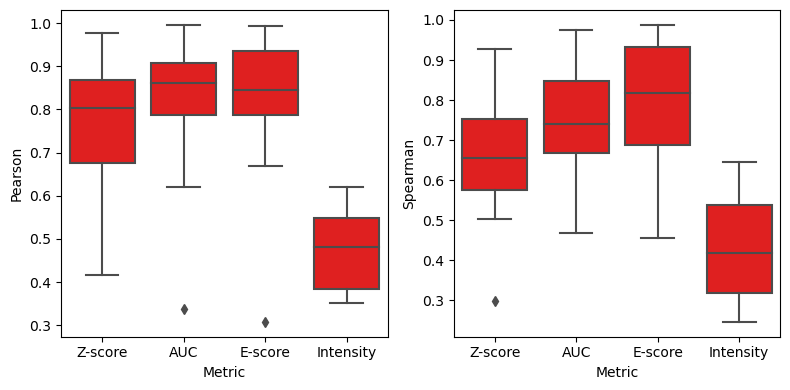

In [6]:
# Plot just the single task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_ST_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_ST_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(settings.figure_dir, "correlation_boxplots_ST.pdf"))
plt.show()

## Multitask model evaluation

In [108]:
# Also need the multi-task columns (single task we could train on all the columns)
sdata_training = sd.open_zarr(os.path.join(settings.dataset_dir, "norm_setA_sub_MT.zarr"))

In [109]:
keys_MT = pd.Index(sdata_training.data_vars.keys())
target_mask_MT = keys_MT.str.contains("RNCMPT")
target_cols_MT = keys_MT[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [110]:
# Get predictions on the test data from all multi task models
print("Testing DeepBind MultiTask model on")
version = 0
arch = models.zoo.DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=len(target_cols_MT), # Number of multitask outputs
    conv_kwargs=dict(input_channels=4, conv_channels=[1024], conv_kernels=[16], dropout_rates=0.25, batchnorm=0.25),
    dense_kwargs=dict(hidden_dims=[512], dropout_rates=0.25, batchnorm=True),
)
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = models.SequenceModule.load_from_checkpoint(model_file, arch=arch)

Testing DeepBind MultiTask model on


In [111]:
evaluate.predictions_sequence_module(
    model,
    sdata=sdata_test,
    seq_key="ohe_seq",
    target_keys=target_cols_MT,
    batch_size=1024,
    num_workers=4,
    prefetch_factor=2,
    in_memory=True,
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32), "target": lambda x: torch.tensor(x, dtype=torch.float32)},
    name="DeepBind_MT",
    version=f"v{version}",
    file_label="test",
    suffix="_MT"
)

Loading ohe_seq and Index(['RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004',
       'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00010',
       'RNCMPT00011', 'RNCMPT00012',
       ...
       'RNCMPT00280', 'RNCMPT00281', 'RNCMPT00282', 'RNCMPT00283',
       'RNCMPT00284', 'RNCMPT00285', 'RNCMPT00287', 'RNCMPT00288',
       'RNCMPT00289', 'RNCMPT00291'],
      dtype='object', length=233) into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [117]:
# Get evaluation metrics for all single task models and format for plotting
pearson_MT_df, spearman_MT_df = rnacomplete_metrics_sdata_table(sdata_test, b_presence_absence, target_cols_MT[:10], verbose=False, swifter=True, num_kmers=10, preds_suffix="_predictions_MT")
pearson_MT_long = pearson_MT_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_MT_long = spearman_MT_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_MT_long["Model"] = "MultiTask"
spearman_MT_long["Model"] = "MultiTask"

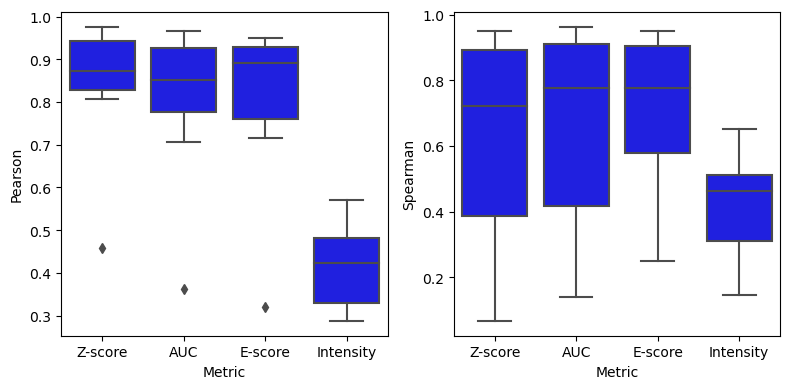

In [120]:
# Plot just the multi task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_MT_long, x="Metric", y="Pearson", color="blue", ax=ax[0])
sns.boxplot(data=spearman_MT_long, x="Metric", y="Spearman", color="blue", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(settings.figure_dir, "correlation_boxplots_MT.pdf"))

## Kipoi models

In [3]:
sys.path.append("/cellar/users/aklie/projects/ML4GLand/external/")
from kipoi_ext import get_model_names, get_model

In [4]:
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"

In [14]:
# Load the test data
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, "norm_setB_processed_ST.h5sd"))
target_mask = sdata_test.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_test.seqs_annot.columns[target_mask]
sdata_test

SeqData object with = 121031 seqs
seqs = (121031,)
names = (121031,)
rev_seqs = None
ohe_seqs = (121031, 4, 41)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004', 'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00011', 'RNCMPT00012', 'RNCMPT00013', 'RNCMPT00014', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00017', 'RNCMPT00018', 'RNCMPT00019', 'RNCMPT00020', 'RNCMPT00021', 'RNCMPT00022', 'RNCMPT00023', 'RNCMPT00024', 'RNCMPT00025', 'RNCMPT00026', 'RNCMPT00027', 'RNCMPT00028', 'RNCMPT00029', 'RNCMPT00031', 'RNCMPT00032', 'RNCMPT00033', 'RNCMPT00034', 'RNCMPT00035', 'RNCMPT00036', 'RNCMPT00037', 'RNCMPT00038', 'RNCMPT00039', 'RNCMPT00040', 'RNCMPT00041', 'RNCMPT00042', 'RNCMPT00043', 'RNCMPT00044', 'RNCMPT00045', 'RNCMPT00046', 'RNCMPT00047', 'RNCMPT00049', 'RNCMPT00050', 'RNCMPT00051', 'RNCMPT00052', 'RNCMPT00053', 'RNCMPT00054', 'RNCMPT00055', 'RNCMPT00056', 'RNCMPT00057', 'RNCMPT00058', 'RN

In [11]:
# We need to get the protein IDs from the motifs in the
id_mapping = pd.read_excel(os.path.join(settings.dataset_dir, "hg19_motif_hits", "ID.mapping.xls"), sheet_name=0)
id_mp = id_mapping.set_index("Motif ID")["Protein(s)"]
cols_w_ids = ~target_cols.map(id_mp).isna()
target_cols_w_ids = target_cols[cols_w_ids]
ids_w_target_cols = pd.Index([id.split("(")[0].rstrip() for id in target_cols_w_ids.map(id_mp)])

In [12]:
# Get the kipoi models names
db_model_names = get_model_names("DeepBind/Homo_sapiens/RBP/D")

Already up to date.


In [13]:
db_model_name = db_model_names[db_model_names.str.contains("FMR1")]

In [14]:
model = get_model(db_model_name.values[0])

Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00099.001_RNAcompete_FMR1/arch/cb6cfce1c46c4a23288ebf5ed3a209ad
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00099.001_RNAcompete_FMR1/weights/a9341a78eb350065fb73c1917a94c83a


ValueError: bad marshal data (unknown type code)

In [20]:
model

In [20]:
# Get predictions with each model and store them in sdata
target_cols_w_model = []
for i, (protein_id , motif_id) in tqdm(enumerate(zip(ids_w_target_cols, target_cols_w_ids)), desc="Importing models", total=len(ids_w_target_cols)):
    print("Predicting for protein: ", protein_id, " motif: ", motif_id)
    db_model_name = db_model_names[db_model_names.str.contains(protein_id)]
    if len(db_model_name) == 0:
        print("No model found for protein: ", protein_id)
        continue
    try:
        model = get_model(db_model_name.values[0])
        sdata_test[f"{motif_id}_predictions_kipoi"] = model(sdata_test["ohe_seq"].values.transpose(0,2,1)).cpu().numpy()
        target_cols_w_model.append(motif_id)
    except:
        print("Failed to load model")
    if len(target_cols_w_model) == 5:
        break

Importing models:   0%|          | 0/131 [00:00<?, ?it/s]

Predicting for protein:  A1CF  motif:  RNCMPT00001
Failed to load model
Predicting for protein:  ANKHD1  motif:  RNCMPT00002
Failed to load model
Predicting for protein:  CELF4  motif:  RNCMPT00004
No model found for protein:  CELF4
Predicting for protein:  CNOT4  motif:  RNCMPT00008
Failed to load model
Predicting for protein:  CPEB2  motif:  RNCMPT00012
Failed to load model
Predicting for protein:  DAZAP1  motif:  RNCMPT00013
Failed to load model
Predicting for protein:  FMR1  motif:  RNCMPT00016
Failed to load model
Predicting for protein:  RBFOX1  motif:  RNCMPT00017
Failed to load model
Predicting for protein:  BX511012.1  motif:  RNCMPT00019
No model found for protein:  BX511012.1
Predicting for protein:  FXR1  motif:  RNCMPT00020
Failed to load model
Predicting for protein:  G3BP1  motif:  RNCMPT00021
No model found for protein:  G3BP1
Predicting for protein:  HNRNPA1  motif:  RNCMPT00022
Failed to load model
Predicting for protein:  HNRNPA1  motif:  RNCMPT00023
Failed to load m

In [ ]:
# Save the sdata with kipoi predictions
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))

In [ ]:
# Evaluate the predictions using the RNAcompete metrics
pearson_kipoi_df, spearman_kipoi_df = eu.predict.rnacomplete_metrics_sdata_table(sdata_test, b_presence_absence, target_cols_w_model, verbose=False, num_kmers=5, preds_suffix="_predictions_kipoi")
pearson_kipoi_long = pearson_kipoi_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_kipoi_long = spearman_kipoi_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_kipoi_long["Model"] = "Kipoi"
spearman_kipoi_long["Model"] = "Kipoi"

In [ ]:
# Plot just the kipoi results as boxplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_kipoi_long, x="Metric", y="Pearson", color="orange", ax=ax[0])
sns.boxplot(data=spearman_kipoi_long, x="Metric", y="Spearman", color="orange", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(settings.figure_dir, "correlation_boxplots_kipoi_10kmers_.pdf"))
plt.show()

In [ ]:
pearson_kipoi_long.to_csv(os.path.join(eu.settings.output_dir, f"pearson_performance_{number_kmers}kmers_kipoi.tsv"), index=False, sep="\t")
spearman_kipoi_long.to_csv(os.path.join(eu.settings.output_dir, f"spearman_performance_{number_kmers}kmers_kipoi.tsv"), index=False, sep="\t")

---